In [138]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba as nb
from sklearn.metrics import r2_score

In [139]:
@nb.njit
def find_intercepts(x, y, z, plane_height):
    """
    Identify the intercepts where a 3D trajectory crosses a horizontal plane at a specified height.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - z (array of float): The z-coordinates of the trajectory, representing vertical position.
    - plane_height (float): The height of the plane to check for intercepts.
    
    Returns:
    - tuple of arrays: Two arrays containing the x and y coordinates of the points where the trajectory crosses the specified height.
    """
    x_intercept = []
    y_intercept = []
    for i in range(len(z) - 1):
        if z[i] < plane_height and z[i + 1] > plane_height:
            x_intercept.append(x[i])
            y_intercept.append(y[i])
    return np.array(x_intercept), np.array(y_intercept)

@nb.njit
def find_intercepts_2d(x, y, plane_height):
    """
    Identify the intercepts where a 3D trajectory crosses a horizontal plane at a specified height.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - plane_height (float): The height of the plane to check for intercepts.
    
    Returns:
    - tuple of arrays: Two arrays containing the x and y coordinates of the points where the trajectory crosses the specified height.
    """
    x_intercept = []
    y_intercept = []
    for i in range(len(y) - 1):
        if y[i] < plane_height and y[i + 1] > plane_height:
            x_intercept.append(x[i])
            y_intercept.append(y[i])
    return np.array(x_intercept), np.array(y_intercept)

@nb.njit
def smk(x, y, m, k):
    """
    Generate a subset of points from a 2D trajectory using a sliding window approach.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - ndarray: A 2D NumPy array containing points sampled according to the sliding window parameters.
    """
    N = len(x)
    num_points = int(np.floor((N - m) / k))
    s = np.empty((num_points, 2))  # Pre-allocate a NumPy array
    for i in range(num_points):
        index = m + (i * k) - 1
        s[i, 0] = x[index]
        s[i, 1] = y[index]
    return s

@nb.njit
def lmk(x, y, m, k):
    """
    Calculate the approximate length of segments of a 2D trajectory using a sliding window.
    
    Parameters:
    - x (array of float): The x-coordinates.
    - y (array of float): The y-coordinates.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - float: The scaled average distance covered in each segment of the trajectory.
    """
    points = smk(x, y, m, k)
    total_distance = 0.0
    for i in range(len(points) - 1):
        total_distance += np.linalg.norm(points[i + 1] - points[i])
    if len(points) > 1:
        return (total_distance * (len(x) - m)) / (k * (len(points) - 1))
    else:
        return 0.0


@nb.njit
def lk(x, y, k):
    """
    Compute the average length of a 2D trajectory using multiple sliding windows to enhance accuracy.
    
    Parameters:
    - x (array of float): The x-coordinates.
    - y (array of float): The y-coordinates.
    - k (int): The number of sliding windows to apply.
    
    Returns:
    - float: The average length computed over all specified window configurations.
    """
    moyenne = 0.0
    for m in range(1, k + 1):
        moyenne += lmk(x, y, m, k)
    return moyenne / k

@nb.njit
def find_lk_for_k(x, y, z, height, ks=np.arange(1, 20)):
    """
    Apply the Lk method to compute the trajectory length for various configurations of sliding window sizes, 
    evaluated at the intercepts with a specified horizontal plane.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - z (array of float): The z-coordinates of the trajectory.
    - height (float): The height of the plane to find intercepts.
    - ks (array of int, optional): The range of k-values (window sizes) to use.
    
    Returns:
    - tuple: Two arrays, the first containing the k-values used, and the second containing the logarithm of the Lk lengths.
    """
    x_intercept, y_intercept = find_intercepts(x, y, z, height)
    l_de_k = np.zeros(len(ks), dtype=np.float64)
    for i in range(len(ks)):
        l_de_k[i] = lk(x_intercept, y_intercept, ks[i])
    return ks, np.log(l_de_k)

@nb.njit
def average_difference(points):
    """
    Calculate the average difference between consecutive values in a 1D list using Numba for performance optimization.

    Parameters:
    - points (array of float/int): Array of numeric values.

    Returns:
    - float: The average difference between each successive value.
    """
    n = len(points)
    if n < 2:
        return 0.0  # Return 0 if there are not enough points to compare

    total_difference = 0.0
    # Loop through the array of points and calculate the difference between consecutive points
    for i in range(1, n):
        difference = abs(points[i] - points[i-1])
        total_difference += difference

    # Calculate the average difference
    average_diff = total_difference / (n - 1)
    return average_diff


def optimise_plane_lk(x, y, z, height_start=5, height_stop=25, step=1, max_diff=True):
    """
    Optimise the plane height to find the height that maximizes the average difference 
    in the logarithm of the trajectory lengths calculated by the Lk method.

    This function iterates through a range of plane heights and determines the height
    at which the average difference of the logarithm of lengths of trajectories, 
    intercepted at each height, is maximized.

    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - z (array of float): The z-coordinates of the trajectory.
    - height_start (int, optional): The starting height of the plane.
    - height_stop (int, optional): The ending height of the plane.
    - step (int, optional): The increment step between heights.

    Returns:
    - float: The height that maximizes the average difference of the logarithmic lengths.
    """
    possible_height = np.arange(height_start, height_stop, step)

    if max_diff == True :
        max_moy = 0
        best_height = 0
        for h in possible_height:
            lk_of_k = find_lk_for_k(x, y, z, h)[1]
            moyenne_dy = average_difference(lk_of_k)
            if moyenne_dy > max_moy:
                max_moy = moyenne_dy
                best_height = h
    elif max_diff == False:
        max_moy = np.inf
        best_height = 0
        for h in possible_height:
            lk_of_k = find_lk_for_k(x, y, z, h)[1]
            moyenne_dy = average_difference(lk_of_k)
            if moyenne_dy < max_moy:
                max_moy = moyenne_dy
                best_height = h
    return best_height

@nb.njit
def rk4_step(x, y, z, dt, function):
    """
    Perform one step of the Runge-Kutta 4th order method for solving a system of ODEs.

    Parameters:
    - x, y, z: Arrays of x, y, and z coordinates of the trajectory.
    - dt: Time step.

    Returns:
    - x_new, y_new, z_new: Arrays of new x, y, and z coordinates of the trajectory.
    """
    k1_x, k1_y, k1_z = function(x, y, z)
    k2_x, k2_y, k2_z = function(x + 0.5 * dt * k1_x, y + 0.5 * dt * k1_y, z + 0.5 * dt * k1_z)
    k3_x, k3_y, k3_z = function(x + 0.5 * dt * k2_x, y + 0.5 * dt * k2_y, z + 0.5 * dt * k2_z)
    k4_x, k4_y, k4_z = function(x + dt * k3_x, y + dt * k3_y, z + dt * k3_z)
    x_new = x + (dt / 6.0) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
    y_new = y + (dt / 6.0) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    z_new = z + (dt / 6.0) * (k1_z + 2 * k2_z + 2 * k3_z + k4_z)
    return x_new, y_new, z_new

@nb.njit(parallel=True)
def solve_system(function, x0, y0, z0, dt=0.01, num_steps=1000000):
    """
    Solve the system of ODEs using the Runge-Kutta 4th order method.

    Parameters:
    - x0, y0, z0 (float, optional): Initial conditions for the system. Defaults to 0.5, 0.5, and 0.5, respectively.
    - dt (float, optional): Time step. Defaults to 0.01.
    - num_steps (int, optional): Number of time steps. Defaults to 1000000.

    Returns:
    - x, y, z (numpy.ndarray): Arrays of x, y, and z coordinates of the solution of the system.
    """
    x, y, z = np.zeros(num_steps + 1), np.zeros(num_steps + 1), np.zeros(num_steps + 1)
    x[0], y[0], z[0] = x0, y0, z0
    for i in nb.prange(num_steps):
        x[i + 1], y[i + 1], z[i + 1] = rk4_step(x[i], y[i], z[i], dt, function)
    return x, y, z


# Lorenz

In [140]:
@nb.njit
def lorenz(x, y, z, sigma=10.0, rho=28.0, beta=(8.0/3.0)):
    """
    Define the Lorenz system of ODEs.

    Parameters:
    - x, y, z (float): State variables of the Lorenz system.
    - sigma, rho, beta (float, optional): Parameters of the Lorenz system. Defaults to 10.0, 28.0, and (8.0/3.0), respectively.

    Returns:
    - x_dot, y_dot, z_dot (float): Time derivatives of the state variables of the Lorenz system.
    """
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return x_dot, y_dot, z_dot

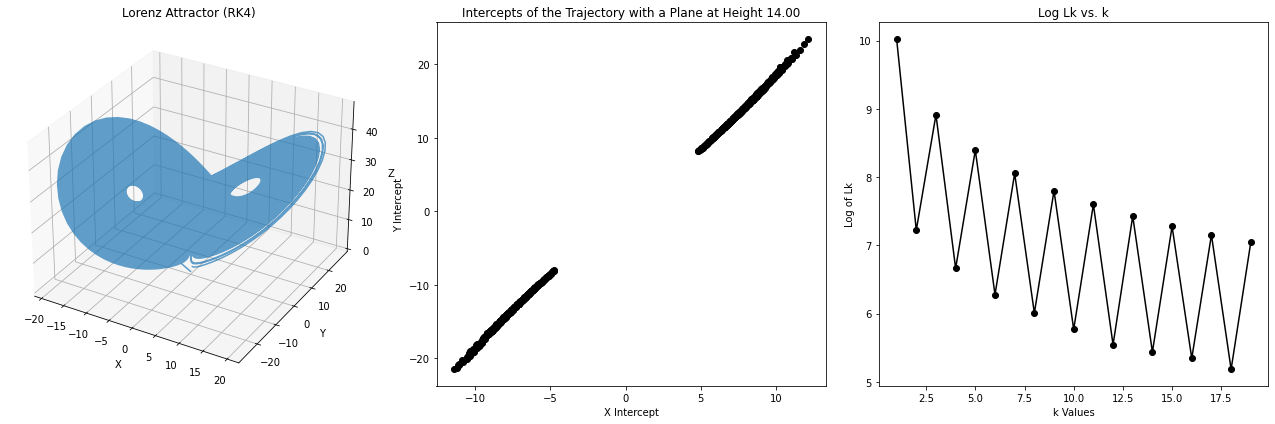

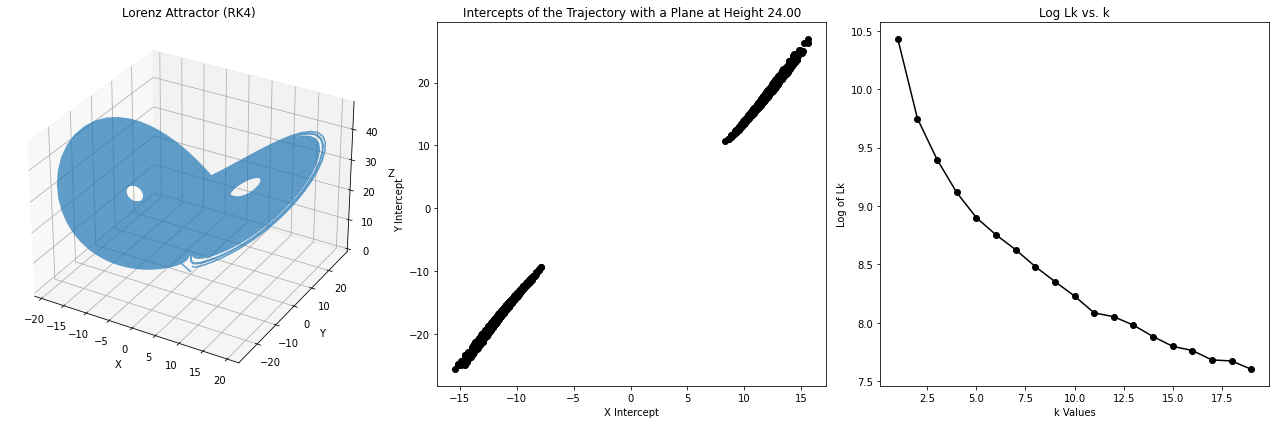

In [141]:
def plot_lorenz_and_more(x, y, z, x_intercept, y_intercept, K, l_of_k, best_h):
    """
    Create a figure with three subplots (side by side) including the Lorenz attractor, intercepts, and a line plot of Lk values.
    
    Parameters:
    - x, y, z (arrays): Coordinates for the Lorenz attractor.
    - x_intercept, y_intercept (arrays): Coordinates for the intercepts.
    - K (array): The k-values for the Lk method.
    - l_of_k (array): The Lk values corresponding to each k.
    """
    # Create a new figure
    fig = plt.figure(figsize=(18, 6))  # Adjusted figure size for horizontal layout

    # Add the first subplot for the Lorenz attractor
    ax1 = fig.add_subplot(131, projection='3d')  # 1 row, 3 columns, position 1
    ax1.plot(x, y, z, alpha=0.7)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Lorenz Attractor (RK4)')

    # Add the second subplot for the intercepts
    ax2 = fig.add_subplot(132)  # 1 row, 3 columns, position 2
    ax2.scatter(x_intercept, y_intercept, marker='o', color='black')
    ax2.set_xlabel('X Intercept')
    ax2.set_ylabel('Y Intercept')
    ax2.set_title(f'Intercepts of the Trajectory with a Plane at Height {best_h:.2f}')

    # Add the third subplot for the Lk method results
    ax3 = fig.add_subplot(133)  # 1 row, 3 columns, position 3
    ax3.plot(K, l_of_k, marker='o', linestyle='-', color='black')
    ax3.set_xlabel('k Values')
    ax3.set_ylabel('Log of Lk')
    ax3.set_title('Log Lk vs. k')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
   
x_lorenz,y_lorenz,z_lorenz= solve_system(lorenz, x0=0.0, y0=1.0, z0=1.05, dt=0.01, num_steps=1000000)
best_h_lorenz = optimise_plane_lk(x_lorenz,y_lorenz,z_lorenz)

x_intercept_lorenz, y_intercept_lorenz = find_intercepts(x_lorenz,y_lorenz,z_lorenz,best_h_lorenz) 
K_lorenz, l_of_k_lorenz = find_lk_for_k(x_lorenz,y_lorenz,z_lorenz,best_h_lorenz)

# Assuming x, y, z, x_intercept, y_intercept, K, and l_of_k are defined as numpy arrays with relevant data
plot_lorenz_and_more(x_lorenz, y_lorenz, z_lorenz, x_intercept_lorenz, y_intercept_lorenz, K_lorenz, l_of_k_lorenz, best_h_lorenz)

worst_h_lorenz = optimise_plane_lk(x_lorenz,y_lorenz,z_lorenz, max_diff=False)
x_intercept_lorenz_worst, y_intercept_lorenz_worst = find_intercepts(x_lorenz,y_lorenz,z_lorenz,worst_h_lorenz) 
K_lorenz_worst, l_of_k_lorenz_worst = find_lk_for_k(x_lorenz,y_lorenz,z_lorenz,worst_h_lorenz)
# Assuming x, y, z, x_intercept, y_intercept, K, and l_of_k are defined as numpy arrays with relevant data
plot_lorenz_and_more(x_lorenz, y_lorenz, z_lorenz, x_intercept_lorenz_worst, y_intercept_lorenz_worst, K_lorenz_worst, l_of_k_lorenz_worst, worst_h_lorenz)


# Noise

In [142]:
@nb.njit
def generate_noise_trajectory(num_points):
    """
    Generate a 3D noise trajectory.

    Parameters:
    - num_points: Number of points in the trajectory.

    Returns:
    - Arrays for x, y, and z coordinates of the noise trajectory.
    """
    x = np.random.randn(num_points)
    y = np.random.randn(num_points)
    z = np.random.randn(num_points)
    return x, y, z

@nb.njit
def determine_x_y_noise(points, height):
    """
    Generate a 3D noise trajectory and find the intercepts with a given plane.

    Parameters:
    - points: Number of points in the trajectory.
    - height: Height of the plane.

    Returns:
    - x_intercept, y_intercept: Arrays of x and y coordinates of the intercepts.
    """
    x, y, z = generate_noise_trajectory(points)
    return find_intercepts(x, y, z, height)

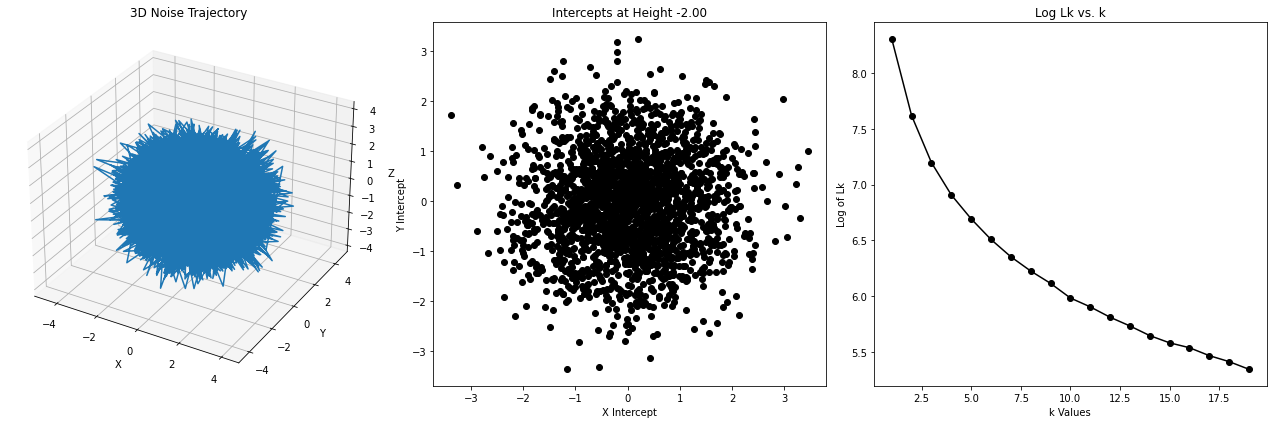

In [143]:
def plot_noise_analysis(x_noise, y_noise, z_noise, x_intercept_noise, y_intercept_noise, K_noise, lk_of_k_noise, best_h_noise):
    """
    Create a figure with three subplots side by side for noise data analysis.

    Parameters:
    - x_noise, y_noise, z_noise (arrays): Coordinates for the noise trajectory.
    - x_intercept_noise, y_intercept_noise (arrays): Coordinates for the intercepts.
    - K_noise (array): The k-values for the Lk method.
    - lk_of_k_noise (array): The Lk values corresponding to each k.
    - best_h_noise (float): The optimized height plane resulting from the analysis.
    """
    fig = plt.figure(figsize=(18, 6))  # Adjusted figure size for horizontal layout

    # Add the first subplot for the 3D noise trajectory
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(x_noise, y_noise, z_noise)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Noise Trajectory')

    # Add the second subplot for the intercepts
    ax2 = fig.add_subplot(132)
    ax2.scatter(x_intercept_noise, y_intercept_noise, color='black')
    ax2.set_xlabel('X Intercept')
    ax2.set_ylabel('Y Intercept')
    ax2.set_title(f'Intercepts at Height {best_h_noise:.2f}')

    # Add the third subplot for the Lk method results
    ax3 = fig.add_subplot(133)
    ax3.plot(K_noise, lk_of_k_noise, marker='o', linestyle='-', color='black')
    ax3.set_xlabel('k Values')
    ax3.set_ylabel('Log of Lk')
    ax3.set_title('Log Lk vs. k')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Assuming necessary functions and data are defined and available
x_noise, y_noise, z_noise = generate_noise_trajectory(100000)
best_h_noise = optimise_plane_lk(x_noise, y_noise, z_noise, height_start=-2, height_stop=2)
x_intercept_noise, y_intercept_noise = determine_x_y_noise(100000, best_h_noise)
K_noise, lk_of_k_noise = find_lk_for_k(x=x_noise, y=y_noise, z=z_noise, height=best_h_noise)

# Now plot everything
plot_noise_analysis(x_noise, y_noise, z_noise, x_intercept_noise, y_intercept_noise, K_noise, lk_of_k_noise, best_h_noise)

# Bouali

In [144]:
@nb.njit
def bouali(x, y, z, a=4.0, b=1.0, c=1.5, s=1.0, alpha=0.3, beta=0.05):
    """
    Define the Bouali system of ODEs.

    Parameters:
    - x, y, z (float): State variables of the Bouali system.
    - a, b, c, s, alpha, beta (float, optional): Parameters of the Bouali system. Defaults to 4.0, 1.0, 1.5, 1.0, 0.3, and 0.05, respectively.

    Returns:
    - x_dot, y_dot, z_dot (float): Time derivatives of the state variables of the Bouali system.
    """
    x_dot = x * (a - y) + (alpha * z)
    y_dot = -y * (b - x**2)
    z_dot = -x * (c - (s * z)) - (beta * z)
    return x_dot, y_dot, z_dot

-4.900000000000004


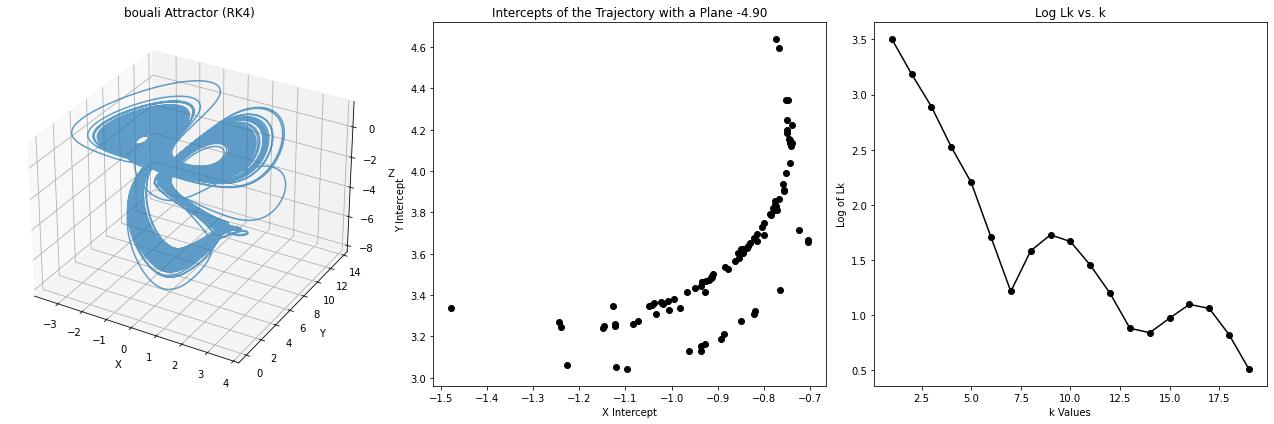

In [145]:
def plot_bouali_and_more(x, y, z, x_intercept, y_intercept, K, l_of_k, best_h):
    """
    Create a figure with three subplots (side by side) including the bouali attractor, intercepts, and a line plot of Lk values.
    
    Parameters:
    - x, y, z (arrays): Coordinates for the bouali attractor.
    - x_intercept, y_intercept (arrays): Coordinates for the intercepts.
    - K (array): The k-values for the Lk method.
    - l_of_k (array): The Lk values corresponding to each k.
    """
    # Create a new figure
    fig = plt.figure(figsize=(18, 6))  # Adjusted figure size for horizontal layout

    # Add the first subplot for the bouali attractor
    ax1 = fig.add_subplot(131, projection='3d')  # 1 row, 3 columns, position 1
    ax1.plot(x, y, z, alpha=0.7)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('bouali Attractor (RK4)')

    # Add the second subplot for the intercepts
    ax2 = fig.add_subplot(132)  # 1 row, 3 columns, position 2
    ax2.scatter(x_intercept, y_intercept, marker='o', color='black')
    ax2.set_xlabel('X Intercept')
    ax2.set_ylabel('Y Intercept')
    ax2.set_title(f'Intercepts of the Trajectory with a Plane {best_h:.2f}')

    # Add the third subplot for the Lk method results
    ax3 = fig.add_subplot(133)  # 1 row, 3 columns, position 3
    ax3.plot(K, l_of_k, marker='o', linestyle='-', color='black')
    ax3.set_xlabel('k Values')
    ax3.set_ylabel('Log of Lk')
    ax3.set_title('Log Lk vs. k')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
   
x_bouali,y_bouali,z_bouali = solve_system(bouali, x0=0.5, y0=0.5, z0=0.5, dt=0.01, num_steps=1000000)
best_h_bouali = optimise_plane_lk(x_bouali,y_bouali,z_bouali,height_start=-6,height_stop=1,step=0.1)
print(best_h_bouali)

x_intercept_bouali, y_intercept_bouali = find_intercepts(x_bouali,y_bouali,z_bouali,best_h_bouali) 
K_bouali, l_of_k_bouali = find_lk_for_k(x_bouali,y_bouali,z_bouali,best_h_bouali)

# Assuming x, y, z, x_intercept, y_intercept, K, and l_of_k are defined as numpy arrays with relevant data
plot_bouali_and_more(x_bouali, y_bouali, z_bouali, x_intercept_bouali, y_intercept_bouali, K_bouali, l_of_k_bouali, best_h_bouali)


# Chen Lee

In [146]:
@nb.njit
def chen_lee(x, y, z, a=5.0, b=-10.0, c=-0.38):
    """
    Defines the Chen-Lee system of ODEs.

    Parameters:
    x (float): first state variable
    y (float): second state variable
    z (float): third state variable
    a (float, optional): parameter (default: 5.0)
    b (float, optional): parameter (default: -10.0)
    c (float, optional): parameter (default: -0.38)

    Returns:
    x_dot, y_dot, z_dot (float): time derivatives of the state variables
    """
    x_dot = (a * x) - (y * z)
    y_dot = (x * z) + (b * y)
    z_dot = ((x * y) / 3) + (c * z)
    return x_dot, y_dot, z_dot

8.299999999999988


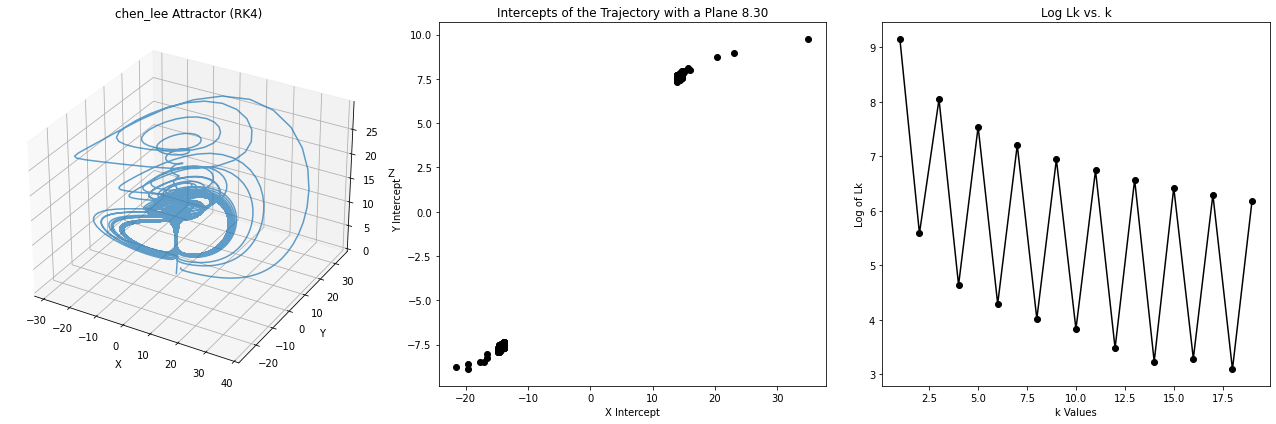

13.49999999999997


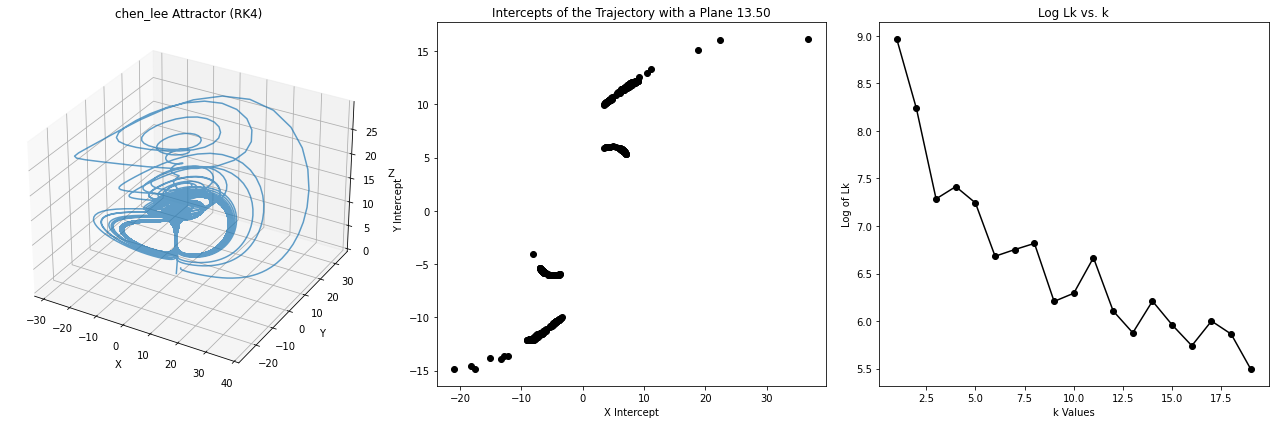

In [147]:
def plot_chen_lee_and_more(x, y, z, x_intercept, y_intercept, K, l_of_k, best_h):
    """
    Create a figure with three subplots (side by side) including the chen_lee attractor, intercepts, and a line plot of Lk values.
    
    Parameters:
    - x, y, z (arrays): Coordinates for the chen_lee attractor.
    - x_intercept, y_intercept (arrays): Coordinates for the intercepts.
    - K (array): The k-values for the Lk method.
    - l_of_k (array): The Lk values corresponding to each k.
    """
    # Create a new figure
    fig = plt.figure(figsize=(18, 6))  # Adjusted figure size for horizontal layout

    # Add the first subplot for the chen_lee attractor
    ax1 = fig.add_subplot(131, projection='3d')  # 1 row, 3 columns, position 1
    ax1.plot(x, y, z, alpha=0.7)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('chen_lee Attractor (RK4)')

    # Add the second subplot for the intercepts
    ax2 = fig.add_subplot(132)  # 1 row, 3 columns, position 2
    ax2.scatter(x_intercept, y_intercept, marker='o', color='black')
    ax2.set_xlabel('X Intercept')
    ax2.set_ylabel('Y Intercept')
    ax2.set_title(f'Intercepts of the Trajectory with a Plane {best_h:.2f}')

    # Add the third subplot for the Lk method results
    ax3 = fig.add_subplot(133)  # 1 row, 3 columns, position 3
    ax3.plot(K, l_of_k, marker='o', linestyle='-', color='black')
    ax3.set_xlabel('k Values')
    ax3.set_ylabel('Log of Lk')
    ax3.set_title('Log Lk vs. k')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


x,y,z = solve_system(chen_lee, x0=1.0, y0=1.0, z0=1.0, dt=0.01, num_steps=1000000)
best_h_chen_lee = optimise_plane_lk(x,y,z,height_start=5,height_stop=14,step=0.1)
print(best_h_chen_lee)

x_intercept_chen_lee, y_intercept_chen_lee = find_intercepts(x,y,z, best_h_chen_lee) 
K, l_of_k = find_lk_for_k(x,y,z,best_h_chen_lee)

# Assuming x, y, z, x_intercept, y_intercept, K, and l_of_k are defined as numpy arrays with relevant data
plot_chen_lee_and_more(x, y, z, x_intercept_chen_lee, y_intercept_chen_lee, K, l_of_k, best_h_chen_lee)

worst_h_chen_lee = optimise_plane_lk(x,y,z,height_start=5,height_stop=14,step=0.1, max_diff=False)
print(worst_h_chen_lee)

x_intercept_chen_lee_worst, y_intercept_chen_lee_worst = find_intercepts(x,y,z, worst_h_chen_lee) 
K, l_of_k = find_lk_for_k(x,y,z,worst_h_chen_lee)

# Assuming x, y, z, x_intercept, y_intercept, K, and l_of_k are defined as numpy arrays with relevant data
plot_chen_lee_and_more(x, y, z, x_intercept_chen_lee_worst, y_intercept_chen_lee_worst, K, l_of_k, worst_h_chen_lee)


# Random Walk

In [148]:
@nb.njit
def random_walk_3d(num_steps):
    """
    Generate a 3D random walk trajectory.

    Parameters:
    - num_steps: Number of steps in the random walk.

    Returns:
    - Arrays for x, y, and z coordinates of the random walk trajectory.
    """
    # Generate random steps in each dimension
    x_steps = np.random.normal(0, 1, num_steps)
    y_steps = np.random.normal(0, 1, num_steps)
    z_steps = np.random.normal(0, 1, num_steps)

    # Calculate cumulative sum to get the trajectory
    x_trajectory = np.cumsum(x_steps)
    y_trajectory = np.cumsum(y_steps)
    z_trajectory = np.cumsum(z_steps)

    return x_trajectory, y_trajectory, z_trajectory

@nb.njit
def determine_x_y_rw(points, height):
    """
    Generate a 3D rw trajectory and find the intercepts with a given plane.

    Parameters:
    - points: Number of points in the trajectory.
    - height: Height of the plane.

    Returns:
    - x_intercept, y_intercept: Arrays of x and y coordinates of the intercepts.
    """
    x, y, z = random_walk_3d(points)
    return find_intercepts(x, y, z, height)

# Generate 3D random walk trajectory
x, y, z = random_walk_3d(100000)

-18.69999999999998


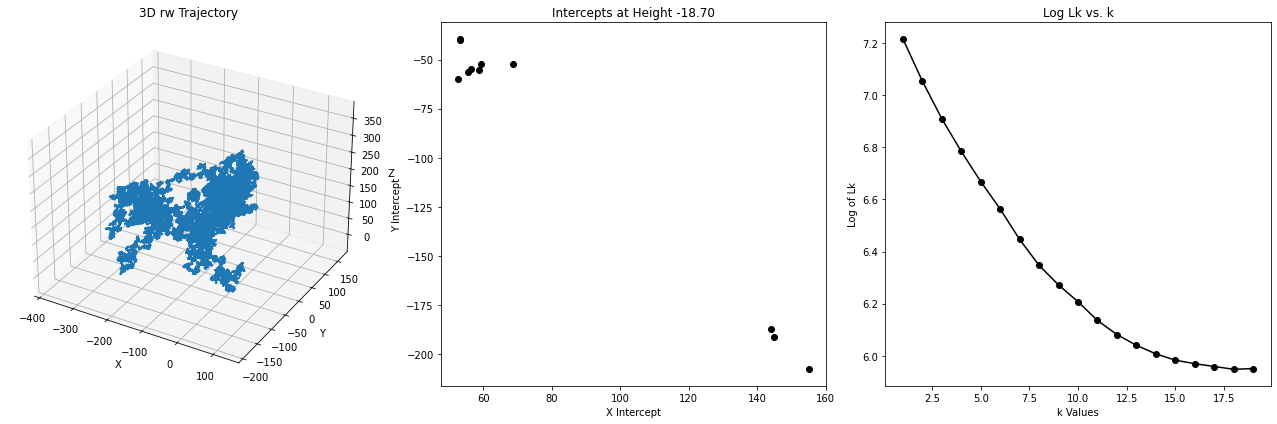

6.800000000000381


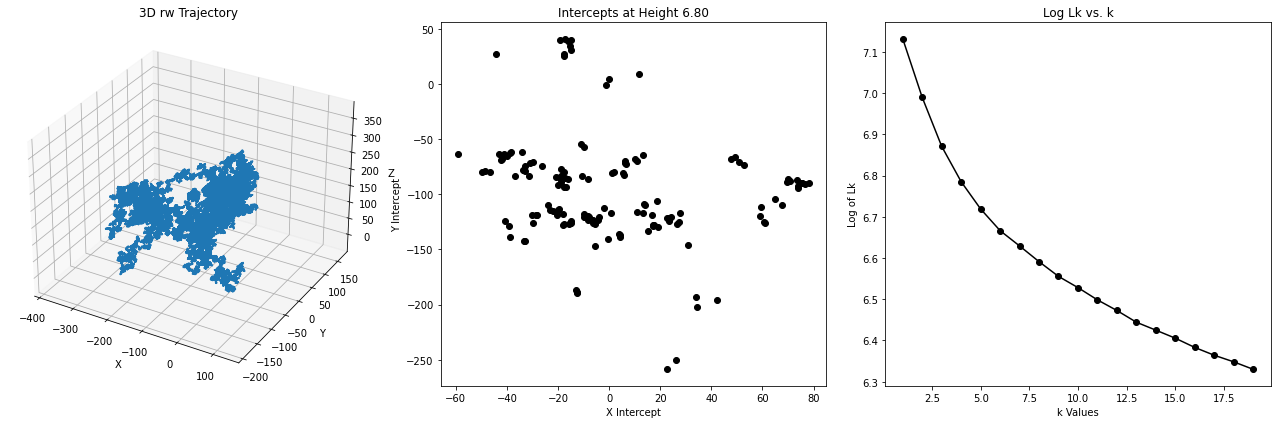

In [149]:
def plot_random_walk_analysis(x_rw, y_rw, z_rw, x_intercept_rw, y_intercept_rw, K_rw, lk_of_k_rw, best_h_rw):
    """
    Create a figure with three subplots side by side for rw data analysis.

    Parameters:
    - x_rw, y_rw, z_rw (arrays): Coordinates for the rw trajectory.
    - x_intercept_rw, y_intercept_rw (arrays): Coordinates for the intercepts.
    - K_rw (array): The k-values for the Lk method.
    - lk_of_k_rw (array): The Lk values corresponding to each k.
    - best_h_rw (float): The optimized height plane resulting from the analysis.
    """
    fig = plt.figure(figsize=(18, 6))  # Adjusted figure size for horizontal layout

    # Add the first subplot for the 3D rw trajectory
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(x_rw, y_rw, z_rw)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D rw Trajectory')

    # Add the second subplot for the intercepts
    ax2 = fig.add_subplot(132)
    ax2.scatter(x_intercept_rw, y_intercept_rw, color='black')
    ax2.set_xlabel('X Intercept')
    ax2.set_ylabel('Y Intercept')
    ax2.set_title(f'Intercepts at Height {best_h_rw:.2f}')

    # Add the third subplot for the Lk method results
    ax3 = fig.add_subplot(133)
    ax3.plot(K_rw, lk_of_k_rw, marker='o', linestyle='-', color='black')
    ax3.set_xlabel('k Values')
    ax3.set_ylabel('Log of Lk')
    ax3.set_title('Log Lk vs. k')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Assuming necessary functions and data are defined and available
x_rw, y_rw, z_rw = random_walk_3d(100000)

best_h_rw = optimise_plane_lk(x_rw, y_rw, z_rw, height_start=-20, height_stop=20,step=0.1)
print(best_h_rw)
x_intercept_rw, y_intercept_rw = determine_x_y_rw(100000, best_h_rw)
K_rw, lk_of_k_rw = find_lk_for_k(x=x_rw, y=y_rw, z=z_rw, height=best_h_rw)

# Now plot everything
plot_random_walk_analysis(x_rw, y_rw, z_rw, x_intercept_rw, y_intercept_rw, K_rw, lk_of_k_rw, best_h_rw)


worst_h_rw = optimise_plane_lk(x_rw, y_rw, z_rw, height_start=-20, height_stop=20,step=0.1, max_diff=False)
print(worst_h_rw)
x_intercept_rw_worst, y_intercept_rw_worst = determine_x_y_rw(100000, worst_h_rw)
K_rw_worst, lk_of_k_rw_worst = find_lk_for_k(x=x_rw, y=y_rw, z=z_rw, height=worst_h_rw)

# Now plot everything
plot_random_walk_analysis(x_rw, y_rw, z_rw, x_intercept_rw_worst, y_intercept_rw_worst, K_rw_worst, lk_of_k_rw_worst, worst_h_rw)